## Importar las bibliotecas necesarias y preparar el entorno

In [99]:
!pip install opencv-python-headless numpy

In [100]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Crear una carpeta 'img' si no existe para guardar las imágenes resultantes
if not os.path.exists('img'):
    os.makedirs('img')

## Inciso1: Definir función para convertir y reescalar imagen

In [101]:
def convert_and_resize(image, scale):
    # Verificar que el parámetro de escala sea al menos 1
    assert scale >= 1, "El parámetro de escala 'k' debe ser al menos 1."
    
    # Convertir de RGB a escala de grises
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Reescalar la imagen a las dimensiones deseadas (128k x 64k)
    resized_image = cv2.resize(gray_image, (128 * scale, 64 * scale), interpolation=cv2.INTER_AREA)
    
    # Devolver la imagen reescalada
    return resized_image.astype(np.float32)  # Usar float32 para seguir el enunciado

## Inciso2: Definir función para calcular magnitud y ángulo del gradiente

In [102]:
def gradient_magnitude_and_angle(image):
    # Definir los filtros de Prewitt para Gx y Gy
    Gx_kernel = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]], dtype=np.float32)
    Gy_kernel = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]], dtype=np.float32)
    
    # Aplicar padding para mantener el tamaño de la imagen tras la convolución
    padded_image = cv2.copyMakeBorder(image, 1, 1, 1, 1, cv2.BORDER_REPLICATE)
    
    # Calcular las correlaciones Gx y Gy
    Gx = cv2.filter2D(padded_image, -1, Gx_kernel)
    Gy = cv2.filter2D(padded_image, -1, Gy_kernel)
    
    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(Gx**2 + Gy**2)
    
    # Calcular el ángulo del gradiente y convertir a grados (con módulo 180)
    angle = (np.arctan2(-Gy, Gx) * (180 / np.pi)) % 180
    
    # Quitar el padding de la imagen resultante
    magnitude = magnitude[1:-1, 1:-1]
    angle = angle[1:-1, 1:-1]
    
    # Devolver la magnitud y el ángulo
    return magnitude, angle

## Cargar imagen, aplicar funciones y visualizar resultados

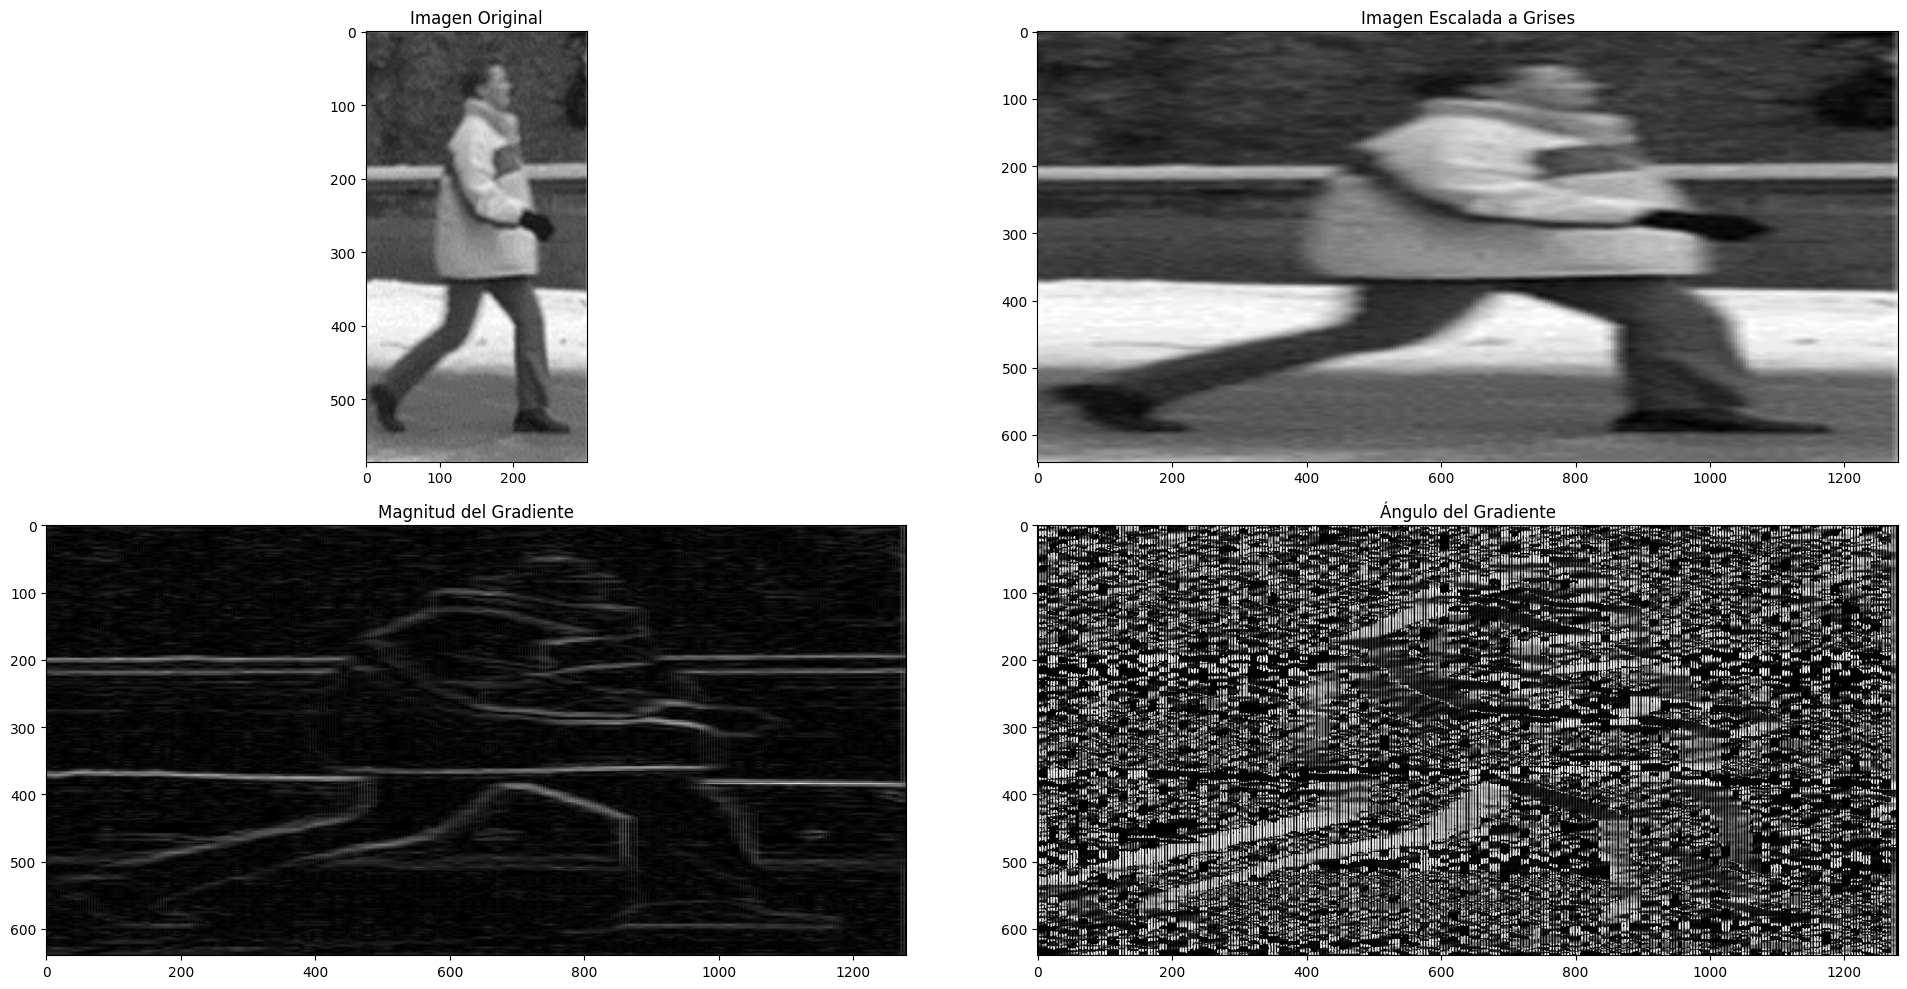

In [103]:
# Cargar la imagen (ajusta la ruta de acuerdo a tu entorno local)
image_path = './img/person.png'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Asegurar que esté en formato RGB para la visualización

# Aplicar la función de conversión y reescalado
scale = 10  # Este valor puede ajustarse
resized_image = convert_and_resize(image, scale)

# Aplicar la función para calcular la magnitud y el ángulo del gradiente
magnitude, angle = gradient_magnitude_and_angle(resized_image)

# Guardar y mostrar los resultados
cv2.imwrite('img/resized_image.png', resized_image)
cv2.imwrite('img/magnitude.png', magnitude)
cv2.imwrite('img/angle.png', angle)

# Visualizar la imagen original, la imagen reescalada, la magnitud y el ángulo del gradiente
plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
plt.imshow(image)
plt.title('Imagen Original')
plt.subplot(2, 2, 2)
plt.imshow(resized_image, cmap='gray')
plt.title('Imagen Escalada a Grises')
plt.subplot(2, 2, 3)
plt.imshow(magnitude, cmap='gray')
plt.title('Magnitud del Gradiente')
plt.subplot(2, 2, 4)
plt.imshow(angle, cmap='gray')
plt.title('Ángulo del Gradiente')
plt.tight_layout()
plt.show()

In [104]:
import numpy as np

def build_blocks(magnitude, angle, block_size, k):
    # El stride es la mitad del tamaño de bloque
    stride = block_size // 2
    
    # Calcular las dimensiones de los stacks de bloques basado en las dimensiones de las imágenes y el stride
    M = (128 * k // stride) - 1
    N = (64 * k // stride) - 1
    
    # Inicializar los stacks de bloques para la magnitud y el ángulo
    blocks_magnitude = np.zeros((M * N, block_size, block_size), dtype=np.float32)
    blocks_angle = np.zeros((M * N, block_size, block_size), dtype=np.float32)
    
    # Construir los stacks de bloques
    block_index = 0
    for i in range(0, magnitude.shape[0] - block_size + 1, stride):
        for j in range(0, magnitude.shape[1] - block_size + 1, stride):
            blocks_magnitude[block_index] = magnitude[i:i + block_size, j:j + block_size]
            blocks_angle[block_index] = angle[i:i + block_size, j:j + block_size]
            block_index += 1
    
    # Verificar que se hayan construido la cantidad correcta de bloques
    assert block_index == M * N, "El número de bloques no coincide con M * N"
    
    return blocks_magnitude, blocks_angle


# Construir los stacks de bloques para la magnitud y el ángulo
block_size = 40  # Este valor puede ajustarse
blocks_magnitude, blocks_angle = build_blocks(magnitude, angle, block_size, scale)


# Imprimir las dimensiones de los stacks de bloques
print(f"Dimensiones de los bloques de magnitud: {blocks_magnitude.shape}")
print(f"Dimensiones de los bloques de ángulo: {blocks_angle.shape}")

Dimensiones de los bloques de magnitud: (1953, 40, 40)
Dimensiones de los bloques de ángulo: (1953, 40, 40)


In [105]:
import numpy as np

def normalize_histogram(hist, epsilon=1e-5):
    return hist / (np.sqrt(np.sum(hist ** 2)) + epsilon)

def build_histogram_of_gradients(magnitude_blocks, angle_blocks, num_bins):
    # Inicializar el array de histogramas con ceros
    histograms = np.zeros((magnitude_blocks.shape[0], num_bins), dtype=np.float32)
    
    # Calcular los centros de los bins del histograma
    bin_centers = np.linspace(0, 180, num_bins, endpoint=False) + (180 / num_bins / 2)
    
    # Iterar sobre cada bloque
    for i in range(magnitude_blocks.shape[0]):
        # Crear el histograma para el bloque actual
        hist = np.zeros(num_bins, dtype=np.float32)
        
        # Calcular el histograma
        for j in range(magnitude_blocks.shape[1]):
            for k in range(magnitude_blocks.shape[2]):
                angle = angle_blocks[i, j, k]
                mag = magnitude_blocks[i, j, k]
                
                # Encontrar el bin más cercano para el ángulo actual
                bin_idx = np.argmin(np.abs(bin_centers - angle))
                hist[bin_idx] += mag
        
        # Normalizar el histograma
        histograms[i] = normalize_histogram(hist)
    
    return histograms

# Supongamos que tienes tus bloques de magnitud y ángulo llamados 'blocks_magnitude' y 'blocks_angle',
# y que deseas usar 9 bins para los histogramas.
# Ejemplo de cómo llamarías a la función:
num_bins = 9
H = build_histogram_of_gradients(blocks_magnitude, blocks_angle, num_bins)

H.shape

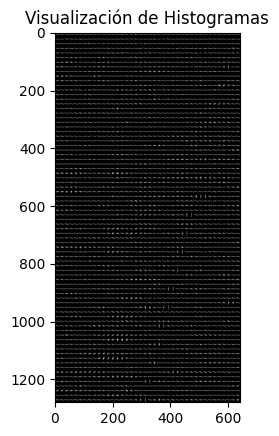

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def create_hist_viz(histograms, block_size, num_bins, image_shape):
    # Calculate the number of vertical and horizontal blocks
    M = image_shape[0] // block_size
    N = image_shape[1] // block_size
    
    # Create an image to visualize the histograms
    visual_image = np.zeros((M * block_size, N * block_size), dtype=np.float32)
    
    # Degree per bin
    deg_per_bin = 180.0 / num_bins
    
    # Iterate over each block's histogram
    for block_idx in range(histograms.shape[0]):
        block_hist = histograms[block_idx]
        (block_row, block_col) = divmod(block_idx, N)
        for bin_idx in range(num_bins):
            # Center of the bin angle
            angle = deg_per_bin * (bin_idx + 0.5)
            # Magnitude is proportional to the histogram bin value
            magnitude = block_hist[bin_idx] * block_size
            # Compute the line's coordinates based on angle and magnitude
            theta = np.deg2rad(angle)
            x_center = block_col * block_size + block_size // 2
            y_center = block_row * block_size + block_size // 2
            dx = int(magnitude * np.cos(theta) * 0.5)
            dy = int(magnitude * np.sin(theta) * 0.5)
            # Draw the line on the visualization image
            cv2.line(visual_image, (x_center - dx, y_center - dy), (x_center + dx, y_center + dy), 255, 1)
    
    return visual_image

original_image_shape = (128 * scale, 64 * scale)  # Assuming the image was resized to this shape
hist_viz = create_hist_viz(H, block_size, num_bins, original_image_shape)

# Display the histogram visualization
plt.imshow(hist_viz, cmap='gray')
plt.title('Visualización de Histogramas')
plt.show()


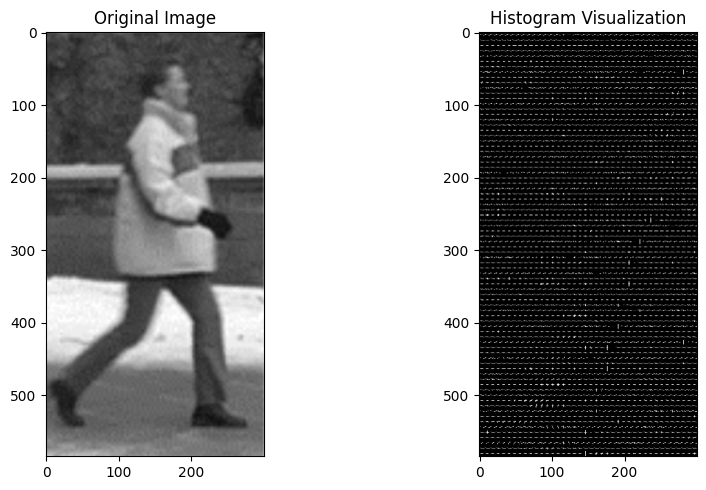

In [ ]:
# Assuming `original_image` is your original image after conversion to grayscale and resizing
# and `hist_viz` is the visualization of histograms you created
original_image = image  # Replace this with your original image
# Resize the histogram visualization to match the original image dimensions if necessary
hist_viz_resized = cv2.resize(hist_viz, (original_image.shape[1], original_image.shape[0]))

# Display the original image and the histogram visualization side by side
plt.figure(figsize=(10, 5))

# Display the original image
plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')

# Display the histogram visualization
plt.subplot(1, 2, 2)
plt.imshow(hist_viz_resized, cmap='gray')
plt.title('Histogram Visualization')

# Show the plots
plt.tight_layout()
plt.show()
